---

# 🧠 Objective

The objective of this project is to build a **binary text classification model** to distinguish between **real** and **fake** news articles.  
We use **word embeddings** and a **custom PyTorch neural network** to learn semantic representations from text and perform classification.

::: {.callout-note}
While this approach may be an **overkill for the small dataset**, it provides an interesting and instructive example of building an end-to-end NLP model using PyTorch.
:::

---

# 🛠️ Project Workflow

1. **🔽 Data Loading**
   - Load datasets for real and fake news.
   - Assign binary labels: `1` for real, `0` for fake.

2. **🧹 Text Preprocessing**
   - Merge `title` and `text` fields into a `content` column.
   - Clean the text by removing stopwords and non-alphabetic tokens.

3. **🔤 Vocabulary & Tokenization**
   - Build a vocabulary from the training set.
   - Tokenize text and convert tokens into integer IDs.

4. **📦 Dataset and DataLoader Setup**
   - Define a custom `TextClassificationDataset` class.
   - Use `nn.EmbeddingBag` for efficient word embedding.
   - Create PyTorch `DataLoader`s for training and validation sets.

5. **🧠 Model Architecture**
   - Define a feed-forward neural network with embeddings.
   - Train the model using cross-entropy loss and an optimizer like Adam.

6. **📈 Training & Validation**
   - Train the model over multiple epochs.
   - Monitor performance using a validation set.

7. **🚫 No Test Evaluation**
   - This notebook focuses on training and validating the model.
   - No separate test set evaluation is performed.

---

# 📦 Importing Libraries

We begin by importing the necessary libraries for:

- Tokenization (`tokenizers`, `nltk`)
- Dataset preparation (`torch`, `sklearn`)
- Model building (`torch.nn`)
- Data handling (`pandas`, `tqdm`)
  
Warnings are suppressed for cleaner output.


In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# 📂 Loading Datasets

We load two datasets:
- `True.csv` for real news articles
- `Fake.csv` for fake news articles

We only select the `title` and `text` columns from each file.


In [2]:
real = pd.read_csv('True.csv', usecols=['title', 'text'])
fake = pd.read_csv('Fake.csv', usecols=['title', 'text'])

## 👀 Previewing Real News Data

Let’s inspect the first few rows of the real news dataset to understand its structure and content.

In [3]:
real.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


### 🔍 Observations:
- The dataset contains two textual fields: `title` and `text`.
- The texts are formal news content, often starting with a dateline like “WASHINGTON (Reuters)...”.
This structure will help guide our preprocessing and tokenization strategy.


## 👀 Previewing Fake News Data

Let’s examine the first few rows of the fake news dataset to understand its structure and how it compares to the real news dataset.

This helps verify consistency in formatting and content across both datasets.

In [4]:
fake.head()

,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...


# Data Preparation

## 🏷️ Label Assignment

To enable binary classification, we add a `label` column to each dataset:

- `1` for **real news**
- `0` for **fake news**


In [5]:
real['label'] = 1
fake['label'] = 0

## 🧩 Dataset Combination

We concatenate both the labeled real and fake datasets into one unified DataFrame. This combined dataset will be used for training and evaluation.

In [6]:
df = pd.concat([real, fake], ignore_index=True)

## 🔤 Preparing Stopwords

We load a predefined set of common English stopwords using NLTK. These words typically provide little semantic value and can be removed during preprocessing.

In [7]:
stop_words = set(stopwords.words('english'))

## 🧹 Text Preprocessing Function

We define a function `remove_stopwrods` that:
- Tokenizes the input text
- Removes stopwords and non-alphabetic tokens
- Returns a cleaned version of the input text

In [8]:
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words and word.isalpha()]
    return " ".join(filtered_text)
    

## 🧱 Rebuilding Unified Text Field

We ensure that the `content` field is constructed by combining `title` and `text` again. This guarantees that any previous operations affecting `content` are overwritten and consistent.

In [9]:
df['content'] = df['title'] + ' ' + df['text']

## 🧼 Final Text Cleaning

We apply our custom `remove_stopwrods` function to clean the combined `content` field. This includes removing stopwords and non-alphabetic tokens.

In [10]:
df['content'] = df['content'].apply(remove_stopwords)

## 🔀 Dataset Shuffling

Shuffling the dataset ensures that there is no ordering bias when feeding data to the model.

In [11]:
df = df.sample(frac=1, random_state=101)

## 📊 Final Dataset Structure

We keep only the `content` and `label` columns and reset the index. This creates a clean and consistent structure for downstream model training.

In [12]:
df = df[['content', 'label']].reset_index(drop=True)
df.head()

,content,label
0,Factbox Humanitarian crisis worsens Bangladesh...,1
1,Transgender court hearing set amid fight Trump...,1
2,BRIEFCASES FULL MONEY One Undercover Whistlebl...,0
3,FIVE REASONS Vote Donald Trump Video LANGUAGE ...,0
4,Trump administration sued phone searches borde...,1


::: {.callout-info}
## Preview Output

From the preview, we confirm that each row has cleaned content and an associated binary label.

:::

# 🧾 DataFrame Overview

We check the data type and memory usage of the dataset to confirm its readiness for model processing.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  44898 non-null  object
 1   label    44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


::: {.callout-note}
## Data Overview Output

There are **44,898 samples** with two columns (`content`, `label`). No missing values are present, confirming data integrity.

:::

# 🧱 Custom Dataset Class

This defines a `TextClassificationDataset` PyTorch class to:

- Split the dataset into train/test internally
- Tokenize the content using `tokenizers` library
- Return token IDs and labels in `__getitem__`

This enables flexible loading and tokenization of samples.

In [14]:
class TextClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer=None, text_column='content', label_column='label', train=False):
        super().__init__()

        train_df, test_df = train_test_split(dataframe,
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=dataframe[label_column]
                                            )
        
        if train:
            self.texts = train_df[text_column].tolist()
            self.labels = train_df[label_column].tolist()

            if tokenizer is None:
                self._build_tokenizer(self.texts)
            else:
                self.tokenizer = tokenizer
        else:
            self.texts = test_df[text_column].tolist()
            self.labels = test_df[label_column].tolist()

            if tokenizer is None:
                raise ValueError("Tokenizer must be provided for test split.")

            self.tokenizer = tokenizer
        
    def _build_tokenizer(self, texts):
        self.tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
        self.tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["<unk>", "<pad>"])
        self.tokenizer.train_from_iterator(texts, trainer=trainer)
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        token_ids = self.tokenizer.encode(self.texts[idx]).ids
        token_ids = torch.tensor(token_ids, dtype=torch.long)
        return token_ids, self.labels[idx]

# 📦 Batch Collation Function

We define a `collate_batch` function to:

- Compute offsets for each sample (needed for `EmbeddingBag`)
- Return `token_ids`, `labels`, and `offsets` for batch processing

In [15]:
def collate_batch(batch):
    token_lists, labels = zip(*batch)

    token_ids = torch.cat(token_lists)
    labels = torch.tensor(labels, dtype=torch.long)

    offsets = [0]
    for tokens in token_lists:
        offsets.append(offsets[-1] + len(tokens))

    offsets = torch.tensor(offsets[:-1], dtype=torch.long)
    
    return token_ids, labels, offsets

# 🏗️ Initializing Datasets

We instantiate training and validation dataset objects using our custom class. The tokenizer is trained only on the training set and reused for validation.

In [16]:
train_dataset = TextClassificationDataset(df, train=True)
val_dataset = TextClassificationDataset(df, tokenizer=train_dataset.tokenizer)

# 🔄 Dataloader Setup

We create PyTorch DataLoaders for both training and validation datasets. Batch size and collation function are specified for efficient loading.

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_batch)

In [18]:
next(iter(train_loader))

(tensor([  13,  866,   71,  ...,  575, 1455, 3816]),
 tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]),
 tensor([    0,   156,   465,   704,  1073,  1518,  1714,  2001,  2162,  2612,
          2657,  2871,  3048,  3358,  3377,  3544,  3788,  4101,  4157,  4346,
          4876,  4947,  5058,  5328,  5469,  5486,  5506,  5618,  5833,  5853,
          6045,  6269,  6400,  6545,  6563,  6735,  6883,  6935,  7019,  7316,
          7562,  7872,  7972,  7981,  8034,  8250,  8397,  8782,  8879,  9701,
          9928,  9945, 10179, 10303, 10542, 10753, 10805, 11028, 11091, 11599,
         11609, 12232, 12450, 12813]))

In [19]:
next(iter(val_loader))

(tensor([11271,    87,   548,  ...,  4663,   138,   196]),
 tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]),
 tensor([   0,  331,  449,  513,  884,  977, 1123, 1561, 1947, 2276, 2640, 2848,
         3152, 3415, 3649, 3858]))

# Model Class

In [20]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, num_classes: int):
        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, text, offsets):
        embed = self.embedding(text, offsets)
        return self.fc(embed)

# Model Training and Validation

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_dim = 200
vocab_size = train_dataset.tokenizer.get_vocab_size()

torch.manual_seed(42)

model = TextClassifier(vocab_size, embed_dim, 2).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

epochs = 5

losses = [] 
accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    total_loss = 0.0
    cur_len = 0
    correct = 0

    model.train()
    for text, labels, offsets in train_loader:
        text, labels, offsets = text.to(device), labels.to(device), offsets.to(device)
        outputs = model(text, offsets)

        optimizer.zero_grad()

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size 

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        
        cur_len += batch_size
        

    losses.append(total_loss/cur_len)
    accs.append(correct/cur_len)

    val_loss = 0.0
    cur_len = 0
    correct = 0
    
    with torch.no_grad():
        model.eval()
        for text, labels, offsets in val_loader:
            text, labels, offsets = text.to(device), labels.to(device), offsets.to(device)
            outputs = model(text, offsets)
    
            loss = loss_fn(outputs, labels)
    
            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size 
    
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            
            cur_len += batch_size

    val_loss = val_loss / cur_len
    val_acc = correct / cur_len

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[Epochs: {epoch+1:>{len(str(epochs))}}/{epochs}]",
          f"train_loss: {losses[-1]:.5f}, train_acc: {accs[-1]:.5f}",
          f"val_loss: {val_losses[-1]:.5f}, val_acc: {val_accs[-1]:.5f}",
          sep=" | "
         )

[Epochs: 1/5] | train_loss: 0.20683, train_acc: 0.94370 | val_loss: 0.06314, val_acc: 0.98307
[Epochs: 2/5] | train_loss: 0.04091, train_acc: 0.98963 | val_loss: 0.03342, val_acc: 0.99065
[Epochs: 3/5] | train_loss: 0.01905, train_acc: 0.99611 | val_loss: 0.02316, val_acc: 0.99399
[Epochs: 4/5] | train_loss: 0.01010, train_acc: 0.99817 | val_loss: 0.01761, val_acc: 0.99510
[Epochs: 5/5] | train_loss: 0.00565, train_acc: 0.99911 | val_loss: 0.01415, val_acc: 0.99555


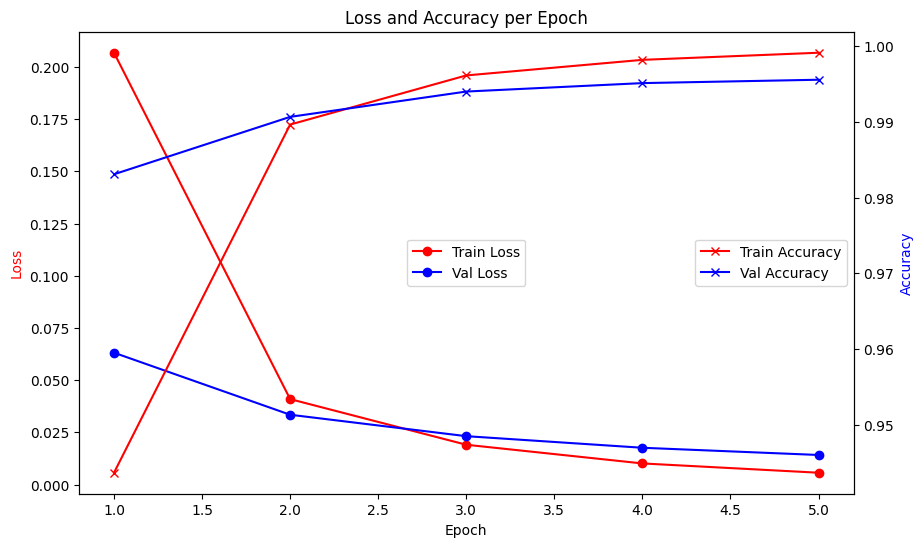

In [22]:
#| label: fig-loss
#| fig-cap: "Loss and Accuracy per epoch"

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(range(1, epochs+1), losses, 'r-o', label='Train Loss')
ax1.plot(range(1, epochs+1), val_losses, 'b-o', label='Val Loss')
ax2.plot(range(1, epochs+1), accs, 'r-x', label='Train Accuracy')
ax2.plot(range(1, epochs+1), val_accs, 'b-x', label='Val Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy', color='b')

ax1.legend(loc='center')
ax2.legend(loc='center right')

plt.title('Loss and Accuracy per Epoch')
plt.show()